$$
\newcommand\P[1]{\mathbb{P}\left(#1\right)} % probability
\newcommand\given{\:\middle\vert\:} % conditional
\newcommand\E[1]{\mathbb{E}\left[#1\right]} % expectation
$$

# A Birthday Problem

Suppose you're on a party and want to impress everyone with your superior ability to memorize mathematical trivia, and maybe you also want to know their birthdays so you can invite yourself to more parties in the future. Then the [Birthday Problem](https://en.wikipedia.org/wiki/Birthday_problem) might be just perfect for you.

If you ask a certain number of persons for their birthdays, how likely is it that two of them will share a birthday? And how many should you expect to have to ask until you find two such people? Most party guests (especially if they are no longer sober) will vastly underestimate the probability of such a coincidence. How to capitalize on their surprise is left as an exercise to the reader.

So what *is* the actual probability? To compute it, let us conveniently ignore all the technicalities that make the problem about actual birthdays, like leap years (pretend February 29 doesn't exist), or the effect of holidays on the birth rate 9 months later, or anything else that might require us to get up from our comfy armchairs and look at real-world statistics.

Then every person $i$ has one of 365 different birthdays, all of which are equally likely, represented by a number $X_i \in \{1, \ldots, 365\}$; and when we ask $k$ different people, we want to know whether there are distinct $i, j \le k$ such that $X_i = X_j$ (persons $i$ and $j$ have the same birthday) and how large $k$ needs to be before that happens.

## Abstract Statement

As a further abstraction of the problem described above, consider <abbr title="independent and identically distributed">i.i.d.</abbr> random variables $X_1, X_2, \ldots$, uniform over $\{1, \ldots, n\}$. Define $K = \min \{k : \exists i < k . X_i = X_k\}$, i.e. $K$ is the index of the first repetition. Then we are interested in

* $\P{K = k}$
* $\P{K \le k}$
* $\E{K}$

## The Probability of a Coincidence

For $k \le 1$ those probabilities are easy to determine: there is no way to find two identical values when you do not even have two values yet! Therefore $\P{K = k} = \P{K \le k} = 0$ for $k \le 1$.

For $k \ge 2$, the probabilities can be determined recursively from earlier values as follows:

\begin{align*}
\P{K = k} &= \P{K = k \given K \ge k}\P{K \ge k} \\
          &= \P{K = k \given K \ge k}\left(1 - \P{K \le k-1}\right) \\
          &= \P{X_k \in \{X_1, \ldots, X_{k-1}\} \given \forall i < j < k . X_i \neq X_j}\left(1 - \P{K \le k-1}\right) \\
          &= \frac{k-1}{n}\left(1 - \P{K \le k-1}\right) \\
\P{K \le k} &= \P{K \le k-1 \vee K = k} \\
            &= \P{K \le k-1} + \P{K = k} \\
            &= \P{K \le k-1} + \frac{k-1}{n}\left(1 - \P{K \le k-1}\right) \\
            &= \P{K \le k-1}\left(1 - \frac{k-1}{n}\right) + \frac{k-1}{n}
\end{align*}

Although those equations aren't quite as simplified as they could be, they are enough for an implementation in code.

In [1]:
def K_leq_k(k, n):
    if k < 2:
        return 0
    return K_leq_k(k-1, n)*(1 - (k-1)/n) + (k-1)/n

In [2]:
def K_eq_k(k, n):
    if k < 2:
        return 0
    return (k-1)/n * (1 - K_leq_k(k-1, n))

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
n = 5

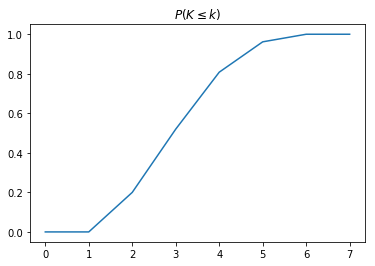

In [5]:
plt.title("$P(K \leq k)$")
plt.plot([K_leq_k(k, n) for k in range(n+3)])
plt.show()

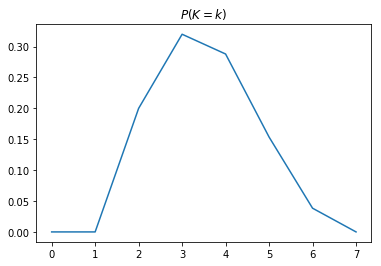

In [6]:
plt.title("$P(K = k)$")
plt.plot([K_eq_k(k, n) for k in range(n+3)])
plt.show()

As expected, $\P{K \leq k}$ approaches 1, while $\P{K = k}$ falls back to 0 for $k \ge n+2$.

In [7]:
sum(K_eq_k(k, n) for k in range(n+3)) # sanity check: should be close to 1

1.0

Using these probabilities, it is now possible to compute the expectation $\E{K}$.

In [8]:
def expectation(distribution, domain):
    "Computes the expectation of a random variable given its distribution and the (finite) domain it ranges over."
    return sum(k*distribution(k) for k in domain)

In [9]:
def E_K(n):
    return expectation(lambda k: K_eq_k(k, n), range(n+3))

In [10]:
E_K(n)

3.5104

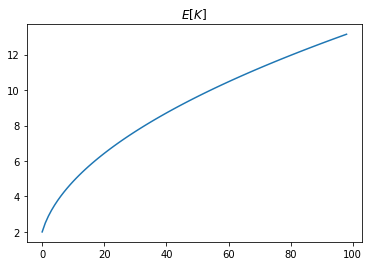

In [11]:
plt.title("$E[K]$")
plt.plot([E_K(n) for n in range(1, 100)])
plt.show()

The curve appears suggestive of a power law. Trying log scale.

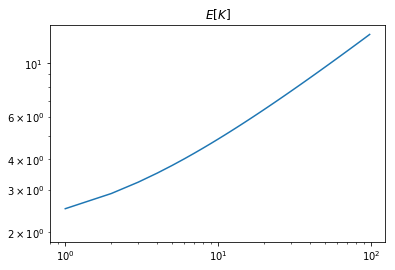

In [12]:
plt.title("$E[K]$")
plt.plot([E_K(n) for n in range(1, 100)])
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.show()

The curve seems to approach a straight line and its slope is given by

In [13]:
import numpy as np

In [14]:
(np.log(E_K(1000))-np.log(E_K(999)))/(np.log(1000)-np.log(999))

0.49164643409963449

i.e. roughly $\frac12$

The intercept is

In [15]:
np.log(E_K(1000)) - 0.5*np.log(1000)

0.2425535514990238

Approximating the original curve by the corresponding power function $e^{1/4}n^{1/2}$ yields

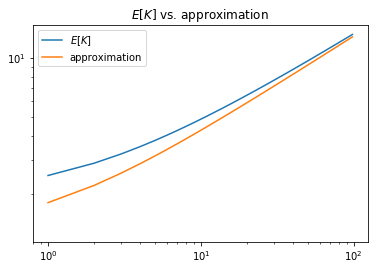

In [16]:
plt.title("$E[K]$ vs. approximation")
plt.plot([E_K(n) for n in range(1, 100)], label='$E[K]$')
plt.plot([np.exp(0.25) * n**0.5 for n in range(1, 100)], label='approximation')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.legend()
plt.show()

With linear axes:

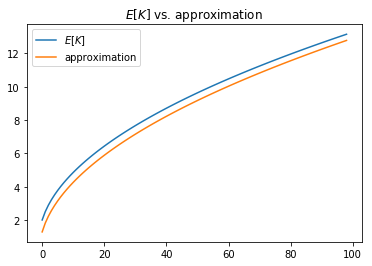

In [17]:
plt.title("$E[K]$ vs. approximation")
plt.plot([E_K(n) for n in range(1, 100)], label='$E[K]$')
plt.plot([np.exp(0.25) * n**0.5 for n in range(1, 100)], label='approximation')
plt.legend()
plt.show()

The distance between curves appears approximately constant.

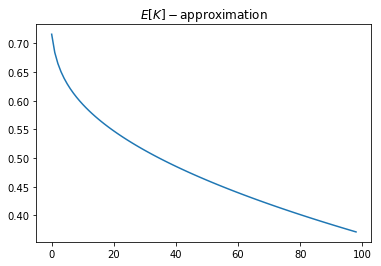

In [18]:
plt.title("$E[K] - $approximation")
plt.plot([E_K(n) - np.exp(0.25) * n**0.5 for n in range(1, 100)])
plt.show()

It isn't. But the steadily shrinking difference does suggest an upper bound of the form $a + b\sqrt{n}$.

## Proving the Upper Bound
<abbr title="to be done (as if!)">TBD</abbr>